In [2]:
import matplotlib.pyplot as plt
import numpy as np
# mongoclient#
import pymongo
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
import scipy.integrate as integrate


from collections import defaultdict

In [2]:
mGClient = MongoClient(f'mongodb://10.250.4.35:27017') 
db = mGClient['experiments']
collection = db['Exp_Daniel_bicipite_t8_btsData']

In [3]:
queryResults = collection.find()

In [4]:
queryResults = [x for x in queryResults]

In [ ]:
# save query queryResults






from pymongo import MongoClient

mGClient = MongoClient(f'mongodb://10.250.4.35:27017') 
db = mGClient['experiments']
collection = db['Exp_Daniel_bicipite_t8_btsData']
queryResults = collection.find()
queryResults = [x for x in queryResults]

with open('queryResults.json', 'w') as f:
    json.dump(queryResults, f)

In [5]:
queryResults[0]

{'_id': ObjectId('6666fbab5bf301c4714ac8c8'),
 'index': 0,
 'samples': [{'sensorLabel': '3', 'value': 0.0, 'status': 0},
  {'sensorLabel': '7', 'value': 0.0, 'status': 0}],
 'timestamp': '2024-06-10T15:12:09.481Z'}

In [6]:
for i in range(len(queryResults)):
    ts_split = queryResults[i]['timestamp'].split('.')
    ts_new = f"{ts_split[0]}.{ts_split[1].zfill(4)}"
    queryResults[i]['timestamp'] = ts_new

In [7]:
tre = []
sensors_dict = defaultdict(list)
for result in queryResults:
    if result['samples'][0]['status'] == 1 and result['samples'][1]["status"] == 1:
        tre.append({"timestamp": result["timestamp"], "tre": result['samples'][0]["value"]})
        sensors_dict[result['samples'][0]['sensorLabel']].append(result['samples'][0]["value"])


In [8]:
df = pd.DataFrame(tre)
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)


In [9]:
def filtering(data: defaultdict) -> defaultdict:
    filtered_data = dict()
    Sampling_frequency = 1000
    band_lo = 20
    band_hi = 450
    Niquist_frequency = Sampling_frequency/2
    nor_band_lo = band_lo/Niquist_frequency
    nor_band_hi = band_hi/Niquist_frequency
    sos_band = signal.iirfilter(4, [ nor_band_lo, nor_band_hi],btype='band', ftype='butter', output = "sos")

    del_freq = 50
    nor_del_freq = del_freq/Niquist_frequency
    Quality = 30
    b, a = signal.iirnotch(nor_del_freq, Quality, Sampling_frequency)

    for key, value in data.items():
        signal_array = np.array(value)
        signal_array_band = signal.sosfiltfilt(sos_band , signal_array[:])
        filtered = signal.lfilter(b, a, signal_array_band)
        signal_array[:] = filtered
        filtered_data[key] = signal_array
    return filtered_data

In [10]:
filtered_dict = filtering(sensors_dict)

In [11]:
df["filtered"] = filtered_dict["3"]

In [12]:
df

tre      filtered
timestamp                                               
2024-06-10 15:12:09.517000+00:00  0.000000  1.377925e-11
2024-06-10 15:12:09.518000+00:00  0.000000  1.502313e-11
2024-06-10 15:12:09.519000+00:00  0.000000  1.614038e-11
2024-06-10 15:12:09.520000+00:00  0.000000  1.709983e-11
2024-06-10 15:12:09.521000+00:00  0.000000  1.786985e-11
...                                    ...           ...
2024-06-10 15:20:09.476000+00:00  0.000000 -5.053537e-07
2024-06-10 15:20:09.477000+00:00  0.000001 -5.246787e-08
2024-06-10 15:20:09.478000+00:00  0.000003  2.277921e-06
2024-06-10 15:20:09.479000+00:00  0.000004  2.965273e-06
2024-06-10 15:20:09.480000+00:00  0.000001  1.639939e-08

[479964 rows x 2 columns]

In [13]:
def rms(data: defaultdict) -> defaultdict:
    """
    Returns the RMS of the data
        Inputs:
            data: database with the data of the sensors
        Outputs:
            rms_data: database with the RMS of the data
    """
    rms_data = defaultdict(list)
    for key, value in data.items():
        for i in range(len(value)):
            signal_array = np.array(value[max(0, i-1999): i+1])
            rms = np.sqrt(np.mean(signal_array[:]**2))
            rms_data[key].append(rms)
    return rms_data


In [14]:
rms_dict = rms(filtered_dict)
df["rms"] = rms_dict["3"]

In [15]:
def meanMedianFreq(data: dict) -> dict:
    """
    Returns the mean frequency, mean power frequency and median frequency of the data
        Inputs:
            data: database with the data of the sensors
        Outputs:
            meanMedianFreq_data: database with the mean frequency, mean power frequency and median frequency of the data
    """
    meanMedianFreq_data = defaultdict(list)
    for key, value in data.items():
        for i in range(len(value)):
            seg_i = value[max(0, i-1999): i+1]
            if seg_i.shape[0] < 2000:
                print("data too short")
                meanMedianFreq_data[key].append((None, None, None))
                continue

            frequency_domain = np.fft.fft(seg_i)
            # Compute magnitude spectrum
            magnitude_spectrum = np.abs(frequency_domain)
            # Identify frequency bins
            N = len(seg_i)
            sampling_rate = 1/1000
            frequency_bins = np.fft.fftfreq(N, d=sampling_rate)
            positive_frequencies = frequency_bins[:N//2]  # consider only positive frequencies
            mean_frequency = np.sum(magnitude_spectrum[:N//2] * positive_frequencies) / np.sum(magnitude_spectrum[:N//2])
            mean_power_frequency = np.sqrt(np.sum(magnitude_spectrum[:N//2] * positive_frequencies**2) / np.sum(magnitude_spectrum[:N//2]))
            # Calculate median frequency
            cumulative_power = np.cumsum(magnitude_spectrum[:N//2])
            half_power = np.sum(magnitude_spectrum[:N//2]) / 2
            median_index = np.argmax(cumulative_power > half_power)
            median_frequency = positive_frequencies[median_index]
            #   print(mean_power_frequency, mean_frequency, median_frequency)
            meanMedianFreq_data[key].append((mean_frequency, mean_power_frequency, median_frequency))
    return meanMedianFreq_data

In [16]:
meanMedianFreq_dict = meanMedianFreq(filtered_dict)

data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too s

In [17]:
df['mean_freq'] = [x[0] for x in meanMedianFreq_dict["3"]]
df['mean_power_freq'] = [x[1] for x in meanMedianFreq_dict["3"]]
df['median_freq'] = [x[2] for x in meanMedianFreq_dict["3"]]

In [66]:
def integrate(data):
    integrale = defaultdict(list)
    integral_prev = 0
    for key, value in data.items():
        for i in range(len(value)):
            integral_now = abs(value[i])*0.001 + integral_prev*0.99996
            integrale[key].append(integral_now)
            integral_prev = integral_now
            # data_batch = sens_1[i:i+200]
            # data_filt = [abs(k[2]) for k in data_batch if k[1]==1]
            # integrals.append(integrate.simpson(data_filt, dx=0.001))
            if i >50000:
                break

    return integrale

In [67]:

def integralBTS(data: defaultdict) -> defaultdict:
    
    integralValue = defaultdict(np.array)
    integralValue["3"] = 0
    integralValue["7"] = 0
    for key, value in data.items():
            # prendiamo i valori di signal array e li moltiplichiamo per 0.001
            signal_array = np.array(value[:50000])
            integrals = np.abs(signal_array) * 0.001
            # calcoliamo la somma pessata dei valori in integrals
            # eg integrals = [1,2,3,4,5] exponents = [0.99996^4, 0.99996^3, 0.99996^2, 0.99996^1, 0.99996^0]
            exponents = np.power(np.ones([50000])*0.99996, 
                                 np.arange(50000)[::-1])
            print(exponents)
            integral_sum = np.sum(integrals*exponents)
            
            integralValue[key] = integral_sum + integralValue[key] * 0.99996**50000

            # for i in range(signal_array.shape[0]):
            #     integral_now = abs(signal_array[i,1])*0.001 + integralValue[key]*0.99996
            #     integralValue[key] = integral_now
        # data_batch = sens_1[i:i+200]
        # data_filt = [abs(k[2]) for k in data_batch if k[1]==1]
        # integrals.append(integrate.simpson(data_filt, dx=0.001))

    return integralValue

In [68]:
import time

In [69]:
timeK = time.time()
print("integrale old ", integrate(filtered_dict)["3"][-1])
k1 = time.time()-timeK

timeK = time.time()
print("integrale new ", integralBTS(filtered_dict)["3"])
k2 = time.time()-timeK

integrale old  0.003253173368610146
[0.13533528 0.1353407  0.13534611 ... 0.99992    0.99996    1.        ]
integrale new  0.003252929290465781


In [70]:
k1-k2

0.021303653717041016

In [ ]:
df['integral'] = integrate(filtered_dict)["3"]


<Axes: xlabel='timestamp'>

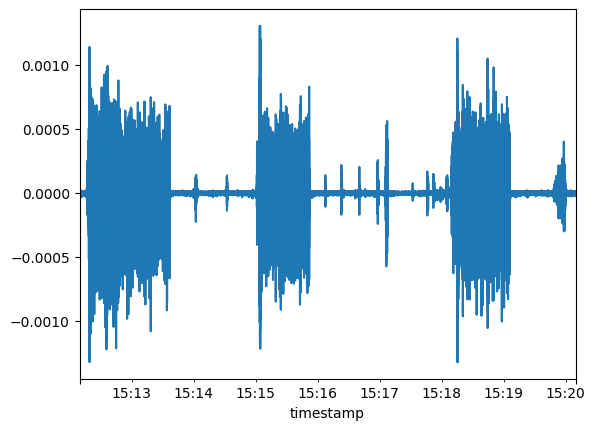

In [19]:
df['tre'].plot()

<Axes: xlabel='timestamp'>

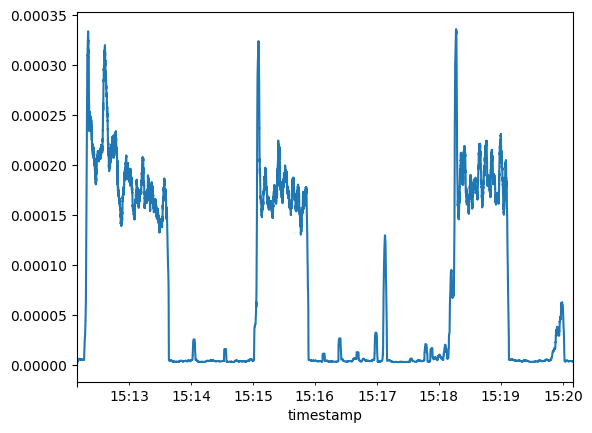

In [20]:
df['rms'].plot()

<Axes: xlabel='timestamp'>

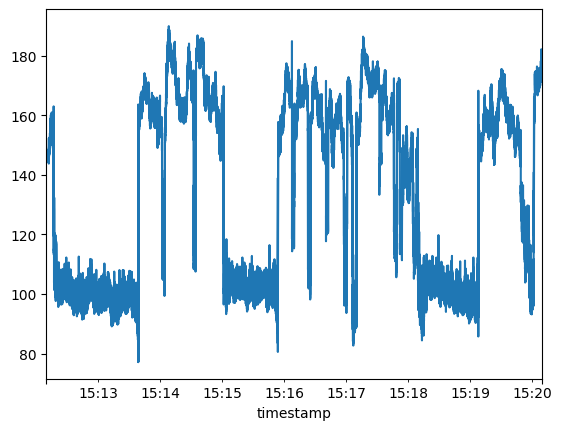

In [21]:
df['mean_freq'].plot()

<Axes: xlabel='timestamp'>

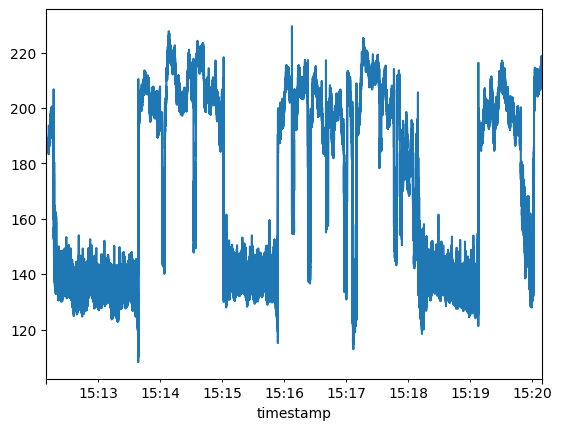

In [22]:
df['mean_power_freq'].plot()

<Axes: xlabel='timestamp'>

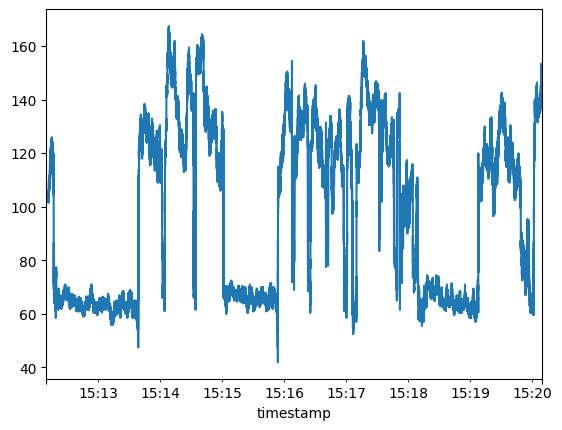

In [23]:
df['median_freq'].plot()

In [24]:
fig = px.line(
    df[(df.index > pd.to_datetime("2024-06-10T15:14:30.748Z")) & 
       (df.index < pd.to_datetime("2024-06-10T15:16:30.848Z"))], 
       
    x=df[(df.index > pd.to_datetime("2024-06-10T15:14:30.748Z")) & 
       (df.index < pd.to_datetime("2024-06-10T15:16:30.848Z"))].index, 
    y="integral"
)
fig.show()

<Axes: xlabel='timestamp'>

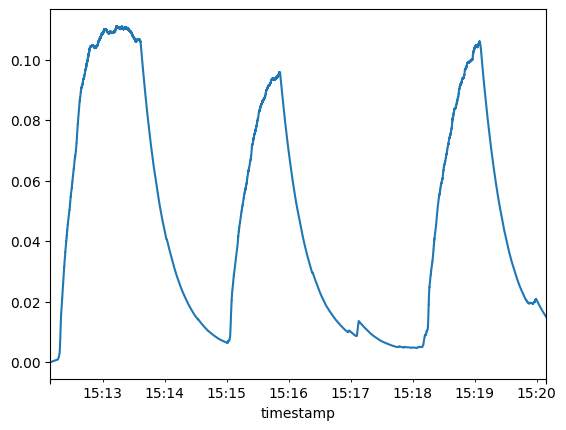

In [25]:
df['integral'].plot()

In [26]:
print(df.loc["2024-06-10T15:13:07.748Z"]["integral"])
print(df.loc["2024-06-10T15:13:36.357Z"]["integral"], '\n')
print(df.loc["2024-06-10T15:15:37.234Z"]["integral"])
print(df.loc["2024-06-10T15:15:51.523Z"]["integral"], '\n')
print(df.loc["2024-06-10T15:18:49.799Z"]["integral"])
print(df.loc["2024-06-10T15:19:05.394Z"]["integral"])

0.10914765945765251
0.10596396286081573 

0.08783123259155351
0.09550300357277212 

0.09462857020710187
0.10527755050969508


# ANDREA

In [38]:
mGClient = MongoClient(f'mongodb://10.250.4.35:27017') 
db = mGClient['experiments']
collection = db['Exp_DanielFornoT4Vero_btsData']

In [39]:
queryResults = collection.find()

In [40]:
queryResults = [x for x in queryResults]

In [41]:
queryResults[0]

{'_id': ObjectId('666b03eff62386e4922d623d'),
 'index': 0,
 'samples': [{'sensorLabel': '5', 'value': 0.0, 'status': 0},
  {'sensorLabel': '8', 'value': 0.0, 'status': 0}],
 'timestamp': '2024-06-13T16:36:31.696Z'}

In [42]:
for i in range(len(queryResults)):
    ts_split = queryResults[i]['timestamp'].split('.')
    ts_new = f"{ts_split[0]}.{ts_split[1].zfill(4)}"
    queryResults[i]['timestamp'] = ts_new

In [43]:
tre = []
sensors_dict = defaultdict(list)
for result in queryResults:
    if result['samples'][0]['status'] == 1 and result['samples'][1]["status"] == 1:
        tre.append({"timestamp": result["timestamp"], "tre": result['samples'][1]["value"]})
        sensors_dict[result['samples'][0]['sensorLabel']].append(result['samples'][1]["value"])


In [44]:
df2 = pd.DataFrame(tre)
df2.set_index('timestamp', inplace=True)
df2.index = pd.to_datetime(df2.index)


In [45]:
def filtering(data: defaultdict) -> defaultdict:
    filtered_data = dict()
    Sampling_frequency = 1000
    band_lo = 20
    band_hi = 450
    Niquist_frequency = Sampling_frequency/2
    nor_band_lo = band_lo/Niquist_frequency
    nor_band_hi = band_hi/Niquist_frequency
    sos_band = signal.iirfilter(4, [ nor_band_lo, nor_band_hi],btype='band', ftype='butter', output = "sos")

    del_freq = 50
    nor_del_freq = del_freq/Niquist_frequency
    Quality = 30
    b, a = signal.iirnotch(nor_del_freq, Quality, Sampling_frequency)

    for key, value in data.items():
        signal_array = np.array(value)
        signal_array_band = signal.sosfiltfilt(sos_band , signal_array[:])
        filtered = signal.lfilter(b, a, signal_array_band)
        signal_array[:] = filtered
        filtered_data[key] = signal_array
    return filtered_data

In [46]:
filtered_dict = filtering(sensors_dict)

In [47]:
df2["filtered"] = filtered_dict["5"]

In [48]:
df2

tre      filtered
timestamp                                               
2024-06-13 16:36:31.807000+00:00  0.000000 -4.053845e-12
2024-06-13 16:36:31.808000+00:00  0.000000 -4.159201e-12
2024-06-13 16:36:31.809000+00:00  0.000000 -4.205781e-12
2024-06-13 16:36:31.810000+00:00  0.000000 -4.186977e-12
2024-06-13 16:36:31.811000+00:00  0.000000 -4.096611e-12
...                                    ...           ...
2024-06-13 16:40:31.691000+00:00  0.000015  1.786090e-05
2024-06-13 16:40:31.692000+00:00  0.000018  1.727673e-05
2024-06-13 16:40:31.693000+00:00  0.000009  6.982448e-06
2024-06-13 16:40:31.694000+00:00  0.000017  1.198063e-05
2024-06-13 16:40:31.695000+00:00  0.000005 -2.288125e-06

[239889 rows x 2 columns]

In [49]:
def rms(data: defaultdict) -> defaultdict:
    """
    Returns the RMS of the data
        Inputs:
            data: database with the data of the sensors
        Outputs:
            rms_data: database with the RMS of the data
    """
    rms_data = defaultdict(list)
    for key, value in data.items():
        for i in range(len(value)):
            signal_array = np.array(value[max(0, i-1999): i+1])
            rms = np.sqrt(np.mean(signal_array[:]**2))
            rms_data[key].append(rms)
    return rms_data


In [50]:
rms_dict = rms(filtered_dict)
df2["rms"] = rms_dict["5"]

In [51]:
def meanMedianFreq(data: dict) -> dict:
    """
    Returns the mean frequency, mean power frequency and median frequency of the data
        Inputs:
            data: database with the data of the sensors
        Outputs:
            meanMedianFreq_data: database with the mean frequency, mean power frequency and median frequency of the data
    """
    meanMedianFreq_data = defaultdict(list)
    for key, value in data.items():
        for i in range(len(value)):
            seg_i = value[max(0, i-1999): i+1]
            if seg_i.shape[0] < 2000:
                print("data too short")
                meanMedianFreq_data[key].append((None, None, None))
                continue

            frequency_domain = np.fft.fft(seg_i)
            # Compute magnitude spectrum
            magnitude_spectrum = np.abs(frequency_domain)
            # Identify frequency bins
            N = len(seg_i)
            sampling_rate = 1/1000
            frequency_bins = np.fft.fftfreq(N, d=sampling_rate)
            positive_frequencies = frequency_bins[:N//2]  # consider only positive frequencies
            mean_frequency = np.sum(magnitude_spectrum[:N//2] * positive_frequencies) / np.sum(magnitude_spectrum[:N//2])
            mean_power_frequency = np.sqrt(np.sum(magnitude_spectrum[:N//2] * positive_frequencies**2) / np.sum(magnitude_spectrum[:N//2]))
            # Calculate median frequency
            cumulative_power = np.cumsum(magnitude_spectrum[:N//2])
            half_power = np.sum(magnitude_spectrum[:N//2]) / 2
            median_index = np.argmax(cumulative_power > half_power)
            median_frequency = positive_frequencies[median_index]
            #   print(mean_power_frequency, mean_frequency, median_frequency)
            meanMedianFreq_data[key].append((mean_frequency, mean_power_frequency, median_frequency))
    return meanMedianFreq_data

In [52]:
meanMedianFreq_dict = meanMedianFreq(filtered_dict)

data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too short
data too s

In [53]:
df2['mean_freq'] = [x[0] for x in meanMedianFreq_dict["5"]]
df2['mean_power_freq'] = [x[1] for x in meanMedianFreq_dict["5"]]
df2['median_freq'] = [x[2] for x in meanMedianFreq_dict["5"]]

In [54]:
def integrate(data):
    integrale = defaultdict(list)
    integral_prev = 0
    for key, value in data.items():
        for i in range(len(value)):
            integral_now = abs(value[i])*0.001 + integral_prev*0.99996
            integrale[key].append(integral_now/0.008)
            integral_prev = integral_now
            # data_batch = sens_1[i:i+200]
            # data_filt = [abs(k[2]) for k in data_batch if k[1]==1]
            # integrals.append(integrate.simpson(data_filt, dx=0.001))

    return integrale

In [55]:
df2['integral'] = integrate(filtered_dict)["5"]


<Axes: xlabel='timestamp'>

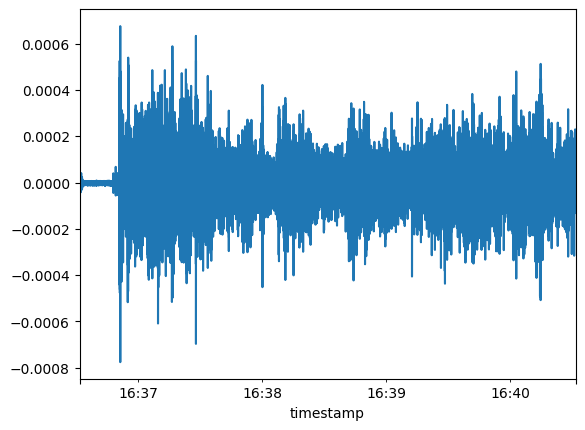

In [56]:
df2['tre'].plot()

<Axes: xlabel='timestamp'>

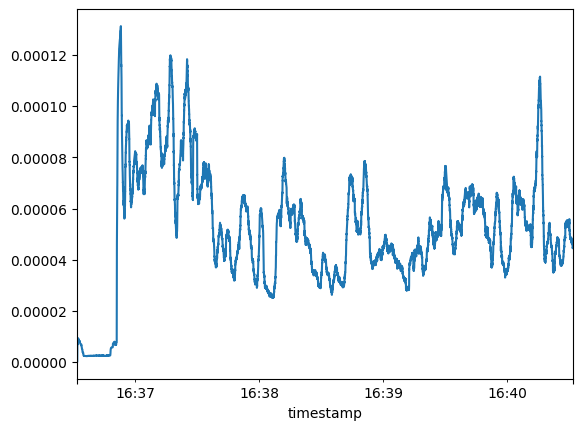

In [57]:
df2['rms'].plot()

<Axes: xlabel='timestamp'>

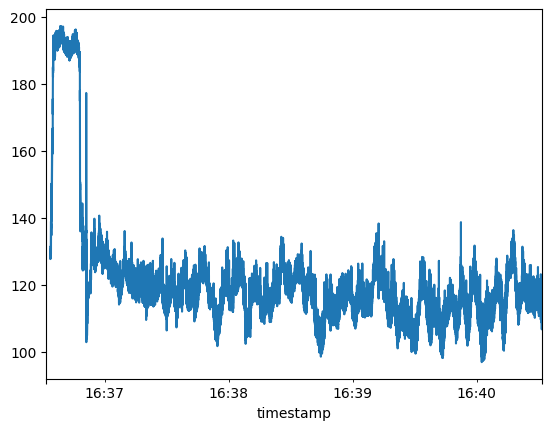

In [58]:
df2['mean_freq'].plot()

<Axes: xlabel='timestamp'>

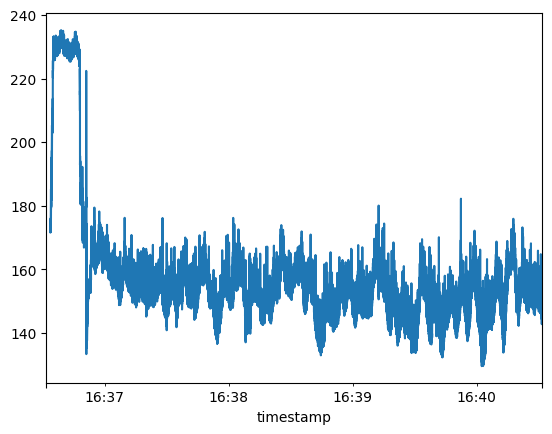

In [59]:
df2['mean_power_freq'].plot()

<Axes: xlabel='timestamp'>

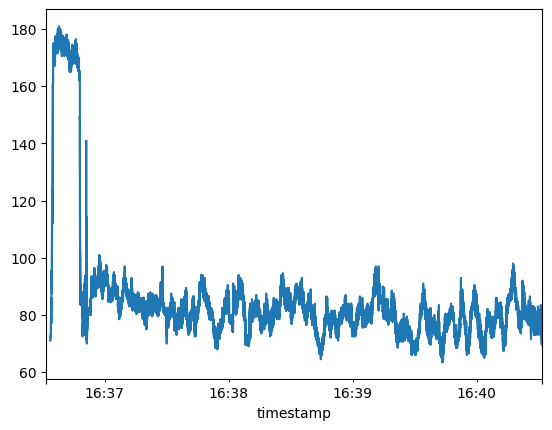

In [60]:
df2['median_freq'].plot()

In [61]:
fig = px.line(
    df2[(df2.index > pd.to_datetime("2024-06-10T15:14:30.748Z")) & 
       (df2.index < pd.to_datetime("2024-06-10T15:16:30.848Z"))], 
       
    x=df2[(df2.index > pd.to_datetime("2024-06-10T15:14:30.748Z")) & 
       (df2.index < pd.to_datetime("2024-06-10T15:16:30.848Z"))].index, 
    y="integral"
)
fig.show()

<Axes: xlabel='timestamp'>

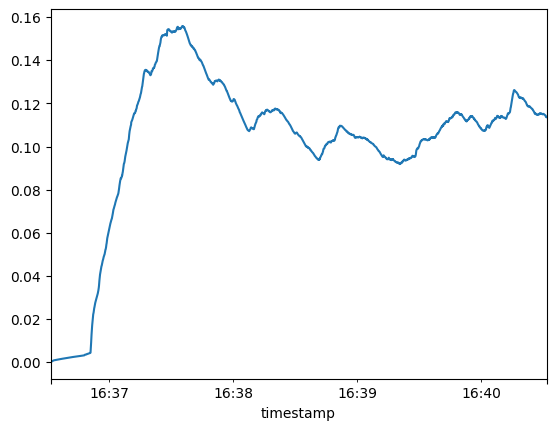

: 

In [62]:
df2['integral'].iloc[::100].plot()

In [ ]:
print(df2.loc["2024-06-11T16:09:50.386Z"]["integral"])
print(df2.loc["2024-06-11T16:11:02.721Z"]["integral"], '\n')
print(df2.loc["2024-06-11T16:13:36.268Z"]["integral"])
print(df2.loc["2024-06-11T16:15:13.262Z"]["integral"], '\n')
print(df2.loc["2024-06-11T16:18:57.252Z"]["integral"])

0.39430640276157103
0.6499835791508217 

0.3947532877948835
0.5797340022736557 

0.5438728309007792
